### Loading variables 

In [81]:
import pandas as pd

from df_information import DataFrameInfo
from data_transform import DataTransform
from df_transform import DataFrameTransform
from plotter import Plotter

In [82]:
# load the data into df
df = pd.read_csv('../loan_payments.csv')

In [83]:
# df_info contains methods that generate useful information about the DataFrame
df_info = DataFrameInfo()

# to do conversions on columns of data (e.g. changing its dtype, or date formats)
data_formatter = DataTransform()

# A df_transformer performs EDA transformations on the dataframe e.g. imputation
df_transformer = DataFrameTransform()

# A class to plot helpful visuals
plotter = Plotter()

Loaded DataFrameInfo()...
Loaded DataTransform()...
Loaded DataFrameTransform()...
Loaded Plotter()...


### Summary statistics 

Calling a few basic functions to get an overview of the dataframe. Calls like .head(), .info, .shape and .describe()

In [84]:
df.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.0,0.0,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.0,0.0,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.0,0.0,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.0,0.0,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.0,0.0,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL


In [85]:
df.shape

(54231, 43)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

### Correct the column formats 

#### Object to Date

In [87]:
# Note how the ouptut format is 'Jan-2021'. we want it to be '2022-01-01'.
# The type of the column is also 'object', and not some kind of date.
df['issue_date'].head()

0    Jan-2021
1    Jan-2021
2    Jan-2021
3    Jan-2021
4    Jan-2021
Name: issue_date, dtype: object

In [88]:
# Columns which are currently objects, but need to be converted to dates 
object_to_date_columns = df[['issue_date', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date', 'earliest_credit_line']]

df = data_formatter.convert_obj_columns_to_date(df, column_list=object_to_date_columns, current_format="%b-%Y")

In [89]:
# The output confirms that the format and dtype have been changed.
df['issue_date'].head()

0   2021-01-01
1   2021-01-01
2   2021-01-01
3   2021-01-01
4   2021-01-01
Name: issue_date, dtype: datetime64[ns]

#### Object to Integer

In [90]:
# The term column contains the values 36 months and 60 months. These may be more usable as integers. 
# In order to do this conversion, I need to first impute the NA values.
df['term'] = df_transformer.impute_nulls_in_column(df['term'], 'mode')
df['term'] = data_formatter.object_to_int(df['term'], {'36 months': 36, '60 months': 60})

#### Object to category 

In [91]:
# Columns which are object types, but are to be converted to categorical types
obj_into_category_column_names = ['grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'application_type', 'payment_plan']
df[obj_into_category_column_names].head()

,grade,sub_grade,employment_length,home_ownership,verification_status,loan_status,purpose,application_type,payment_plan
0,A,A4,5 years,MORTGAGE,Not Verified,Current,credit_card,INDIVIDUAL,n
1,A,A3,9 years,RENT,Not Verified,Current,credit_card,INDIVIDUAL,n
2,A,A4,8 years,MORTGAGE,Source Verified,Fully Paid,credit_card,INDIVIDUAL,n
3,C,C4,1 year,RENT,Source Verified,Fully Paid,debt_consolidation,INDIVIDUAL,n
4,A,A1,10+ years,MORTGAGE,Verified,Current,debt_consolidation,INDIVIDUAL,n


In [92]:
df['application_type'].value_counts()

application_type
INDIVIDUAL    54231
Name: count, dtype: int64

In [93]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    26923
RENT        22493
OWN          4750
OTHER          63
NONE            2
Name: count, dtype: int64

In [94]:
df = data_formatter.convert_object_columns_into_categories(df, obj_into_category_column_names)

#### Numeric to category 

There are some numeric columns, where the vast majority of values are the same, and the rest are spread out with low frequencies. 

Such columns cannot be normally distributed easily, and so I will convert them into categorical columns with ranges to group thier values. 

In [95]:
# This is an example of the kind of value distribution which is better suited to a category with ranges 
df['collection_recovery_fee'].value_counts()

collection_recovery_fee
0.0000      50788
1.4400          7
1.6900          6
1.7300          6
2.0800          6
            ...  
506.8728        1
75.6270         1
2.7103          1
2.1780          1
0.2300          1
Name: count, Length: 2944, dtype: int64

The Series `collections_12_mths_ex_med` only contains 5 values and so it is easy to convert to a category:

In [96]:
df['collections_12_mths_ex_med'].value_counts()

collections_12_mths_ex_med
0.0    53971
1.0      193
2.0       14
3.0        1
4.0        1
Name: count, dtype: int64

In [97]:
# Convert directly into a category 
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].astype('category')

The following 5 columns, (`delinq_2yrs`, `inq_last_6mths`, `recoveries`, `total_rec_late_fee`, ``collection_recovery_fee``), contain many more values, and so I will create ranges from the spread of each columns' data to create the categories. 

In [98]:
df['delinq_2yrs'] = data_formatter.int64_to_category_with_ranges(df, df['delinq_2yrs'])
df['inq_last_6mths'] = data_formatter.int64_to_category_with_ranges(df, df['inq_last_6mths'])

In [99]:
# These columns are all floats, so I will convert them to integers first since no important information is lost in this process.
df['recoveries'] = round(df['recoveries']).astype('Int64')
df['recoveries'] = data_formatter.int64_to_category_with_ranges(df, df['recoveries'])

df['total_rec_late_fee'] = round(df['total_rec_late_fee']).astype('Int64')
df['total_rec_late_fee'] = data_formatter.int64_to_category_with_ranges(df, df['total_rec_late_fee'])

df['collection_recovery_fee'] = round(df['collection_recovery_fee']).astype('Int64')
df['collection_recovery_fee'] = data_formatter.int64_to_category_with_ranges(df, df['collection_recovery_fee'])

#### Float64 to Int64

In [100]:
# These four columns all represent a number of months, and so can be cast to Int64s 
# The capital I in Int64 denotes that it can handle NA's
float64_columns_into_Int64 = df[['mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record']]
float64_columns_into_int64 = data_formatter.convert_float64_columns_into_Int64s(float64_columns_into_Int64)

There are some columns which I am unsure about converting to categories, so I will leave them as they are for now. They are also hard to distribute symetrically, but I am not confident that they actually should be. For future reference, they are:
- last_payment_amount
- open_accounts
- out_prncp_inv
- out_prncp

### Redundant features 

Some columns don't appear to be very useful, so let us see if they are worth removing.

##### grade vs sub_grade

In [101]:
pd.concat([df['grade'], df['sub_grade']], axis=1).head()

,grade,sub_grade
0,A,A4
1,A,A3
2,A,A4
3,C,C4
4,A,A1


Based on the above it seems as though the grade column is redundant, since the grade is always contained in the sub_grade. Let me test this first.

In [102]:
# Check if sub_grade's first letter matches grade 
# Example: if grade is A, sub_grade[0] MUST also be A. This relationship should hold for every grade-sub_grade pair.
grade_matches = df['grade'] == df['sub_grade'].str[0]

# Check if the relationship holds for all pairs 
if grade_matches.all():
  print('True: sub_grade always contains the grade')
else:
  print('False: sub_grade does not always contain the grade')

True: sub_grade always contains the grade


It is true, so I will go ahead and remove grade from the dataframe. 

In [103]:
df = df_transformer.drop_column(df, df['grade'])

##### payment_plan

The value_counts() of payment_plan show that only one value of the ~54,000 values are 'y'. The rest are 'n'. This likely has a negligible impact on my analysis so I will remove this feature.

In [104]:
df['payment_plan'].value_counts()

payment_plan
n    54230
y        1
Name: count, dtype: int64

In [105]:
df = df_transformer.drop_column(df, df['payment_plan'])

##### policy_code and application_type

In [106]:
print(df['policy_code'].nunique(), df['application_type'].nunique())

1 1


In [107]:
# We can see above that there is only 1 value in the policy_code and application_type column, so we may as well delete them.
df = df_transformer.drop_columns(df, ['policy_code', 'application_type'])

### Handle null values

I will first identify the variables with missing values and determine the percentage of missing values in each variable.

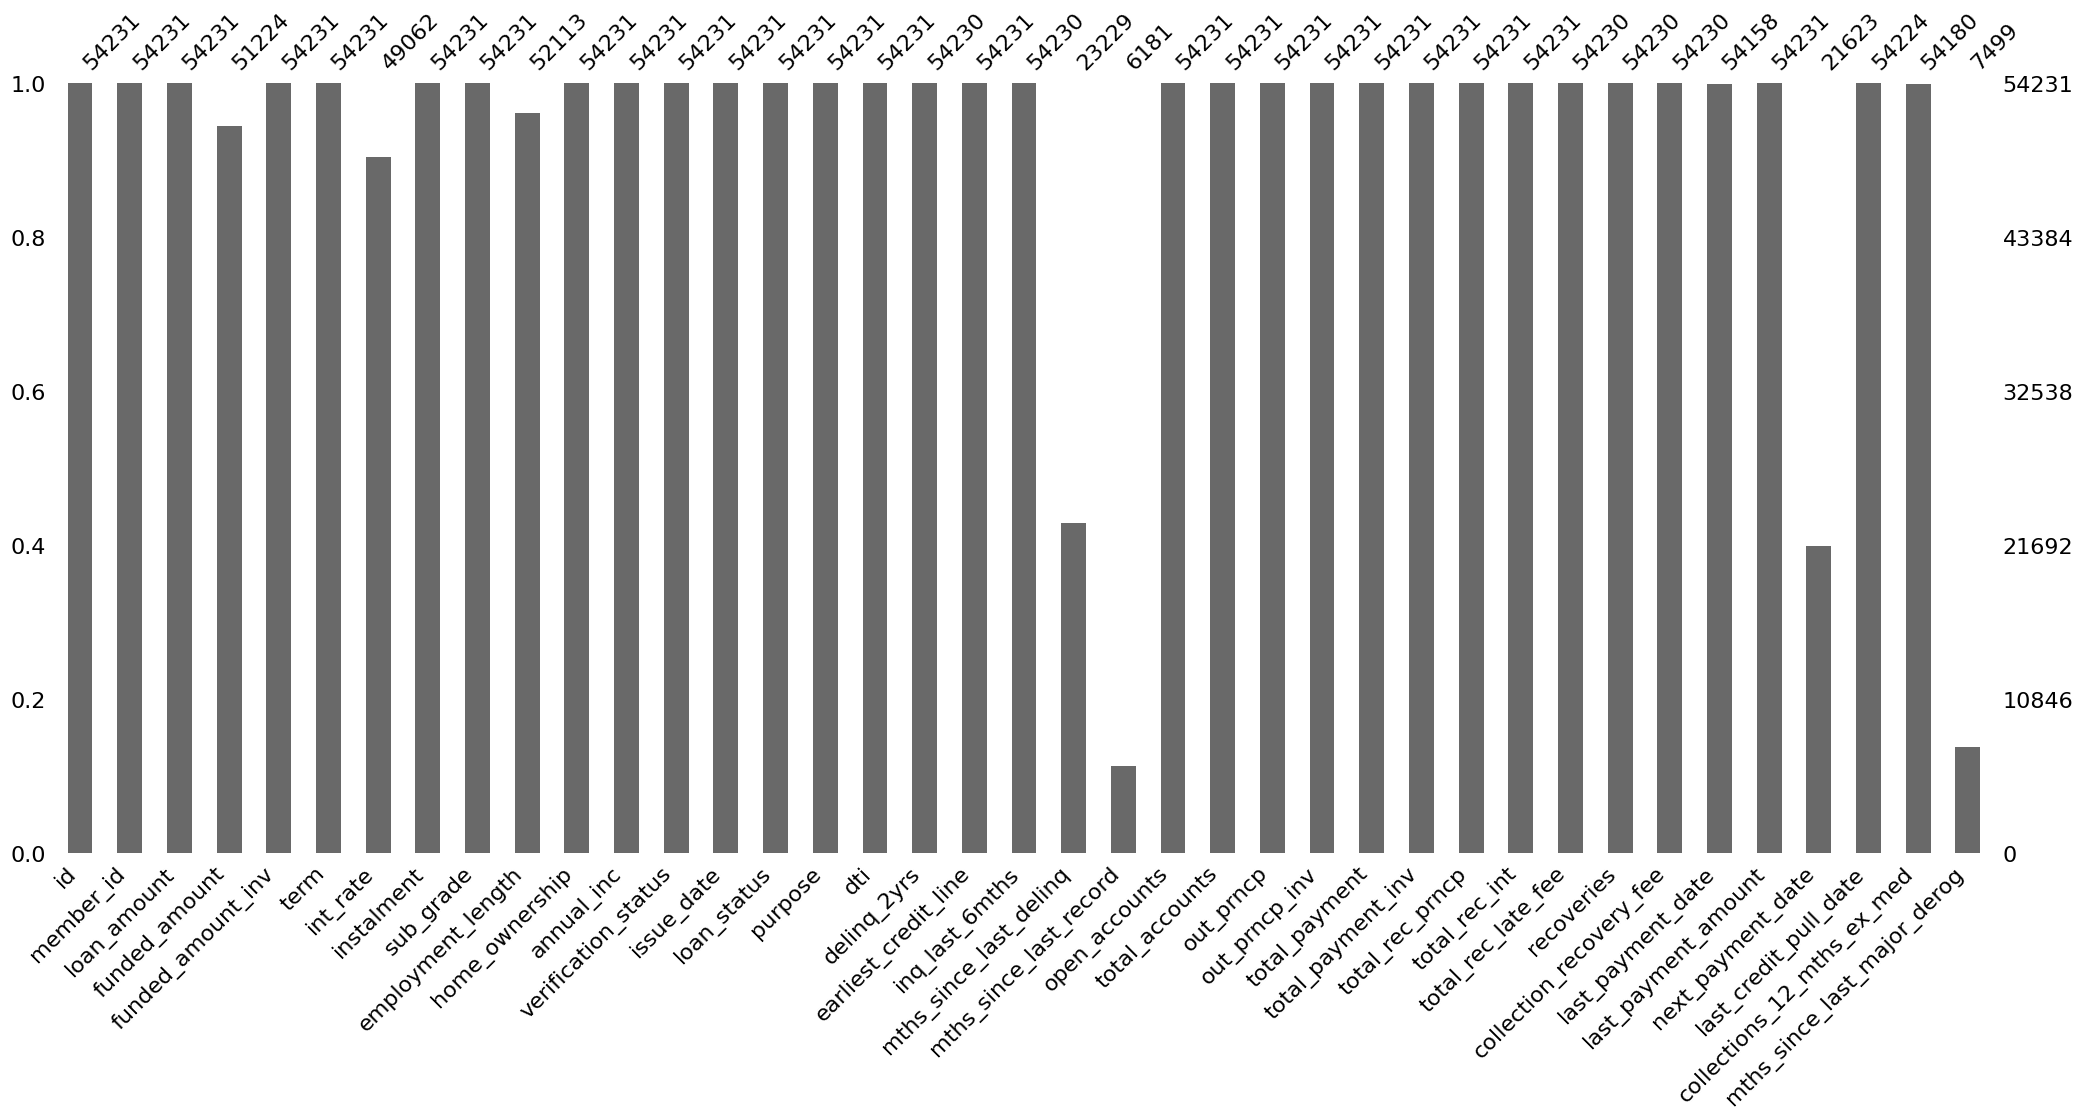

In [108]:
plot = plotter.show_null_bar_chart(df)

In [109]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 15 columns with null values left:



,% of nulls,# of nulls,dtype
mths_since_last_record,88.60,48050,float64
mths_since_last_major_derog,86.17,46732,float64
next_payment_date,60.13,32608,datetime64[ns]
mths_since_last_delinq,57.17,31002,float64
int_rate,9.53,5169,float64
funded_amount,5.54,3007,float64
employment_length,3.91,2118,category
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]


#### Dropping columns

**I now will decide which of the above columns are worth dropping entirely, and proceed to do so.**
Based on the above there are 4 columns with very high proportions of nulls:

`[88.60%, 86.17%, 60.13%, 57.17%]`

The next biggest is 9.53%, which is a huge distance from the top 4.

As a result I am going to *remove all columns with >50% null values*.

In [110]:
# returns a series showing the % of null values for every column in the dataframe
percent_of_nulls = df_info.percentage_of_nulls_in_data_frame(df)

# Extract columns whose majority (> 50%) of values are null, to pass into drop()
more_than_half_null_cols = list(percent_of_nulls[percent_of_nulls > 50.00].index)

# Drop the selected columns from the dataframe
df = df_transformer.drop_columns(df, more_than_half_null_cols)

#### Imputing

In [111]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 11 columns with null values left:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
funded_amount,5.54,3007,float64
employment_length,3.91,2118,category
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category


##### Mode imputations

In [112]:
# The employment_length column is categorical and so mode is the most appropriate replacement. 
df['employment_length'] = df_transformer.impute_nulls_in_column(df['employment_length'], 'mode')

In [113]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 10 columns with null values left:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
funded_amount,5.54,3007,float64
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category
collection_recovery_fee,0.00,1,category


##### Median imputations

For this stage I am simply going to use the average to impute `int_rate` and `funded_amount`.

In [114]:
df['int_rate'] = df_transformer.impute_nulls_in_column(df['int_rate'], 'median')

df['funded_amount'] = df_transformer.impute_nulls_in_column(df['funded_amount'], 'median')

In [115]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 8 columns with null values left:



,% of nulls,# of nulls,dtype
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category
collection_recovery_fee,0.00,1,category


#### Dropping rows 

In [116]:
# These are the last 8 columns, which all have low enough proportions of null values that I am happy to drop the associated rows. 
column_names_with_null_entries = ['last_credit_pull_date', 'collections_12_mths_ex_med', 'last_payment_date', 'delinq_2yrs', 'inq_last_6mths', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee']

df = df_transformer.drop_rows_of_null_column_entries(df, column_names_with_null_entries)

#### Confirm all nulls removed 

In [117]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 0 columns with null values left:



,% of nulls,# of nulls,dtype


<Axes: >

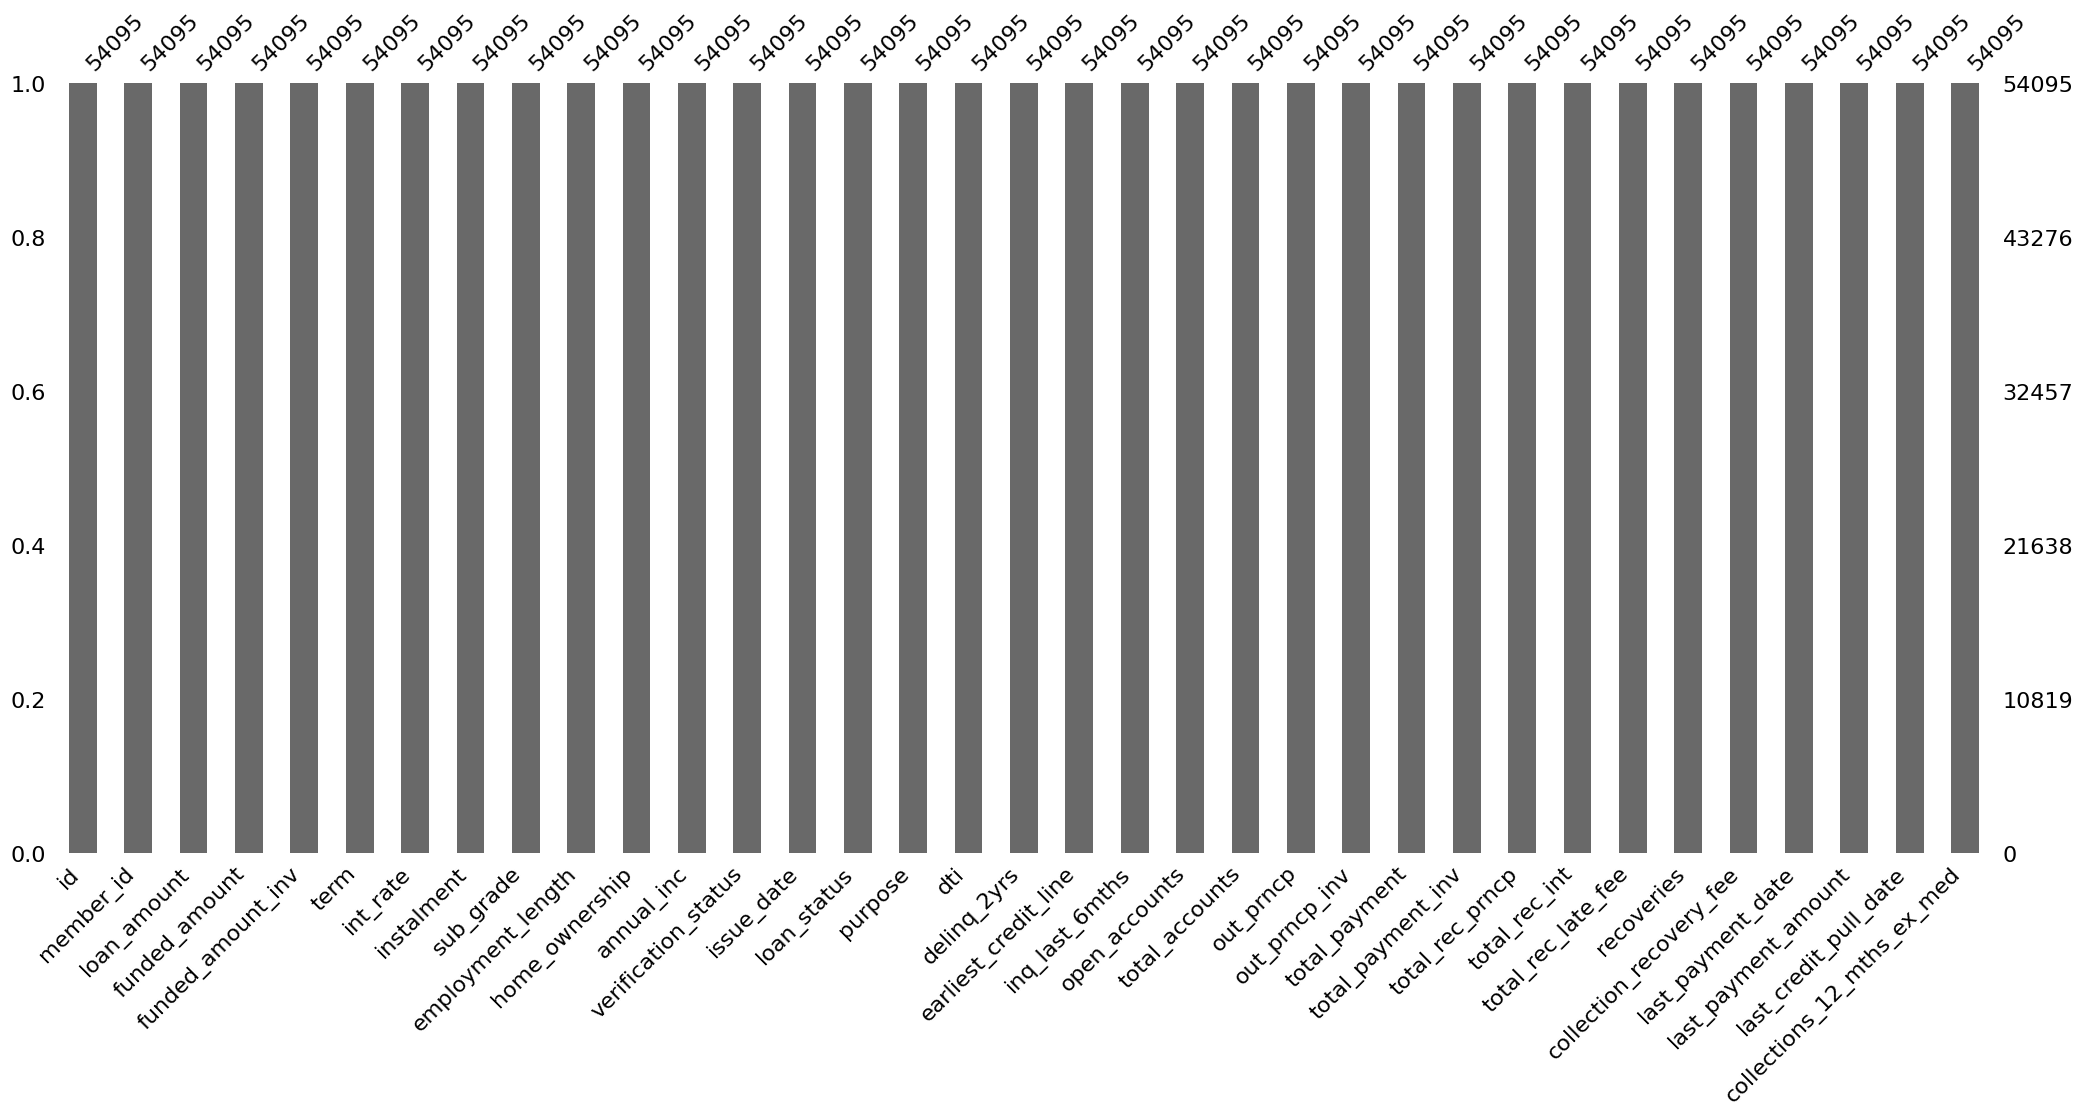

In [118]:
plotter.show_null_bar_chart(df)

### Skewed data

Lets first look at the skew value for each of the columns

In [119]:
# get a series showing the skew value for each column
skew_series = df_info.get_updated_skew_series(df, to_drop=['id', 'member_id'])
skew_series

annual_inc             8.740078
last_payment_amount    2.495972
out_prncp_inv          2.352797
out_prncp              2.352376
total_rec_int          2.203622
total_payment          1.269351
total_rec_prncp        1.261956
total_payment_inv      1.258693
term                   1.146302
open_accounts          1.059783
instalment             0.996249
funded_amount          0.869145
funded_amount_inv      0.814283
loan_amount            0.804361
total_accounts         0.780251
int_rate               0.455883
dti                    0.189027
dtype: float64

In order to decide a cut off point for considering a column as skewed, I will look into those which appear to be normally distributed. 

The table above shows the skewness of the numeric features, sorted with the highest first. 

The closer a skew value is to 0, the more normally distributed it is; those lower in the table have the least skew.

To determine a cuttoff point for skewness *I will look at the kde histplot for each of the **last 4** values in the table*, focusing on how the rise in the skew value affects the extend of the skew. 

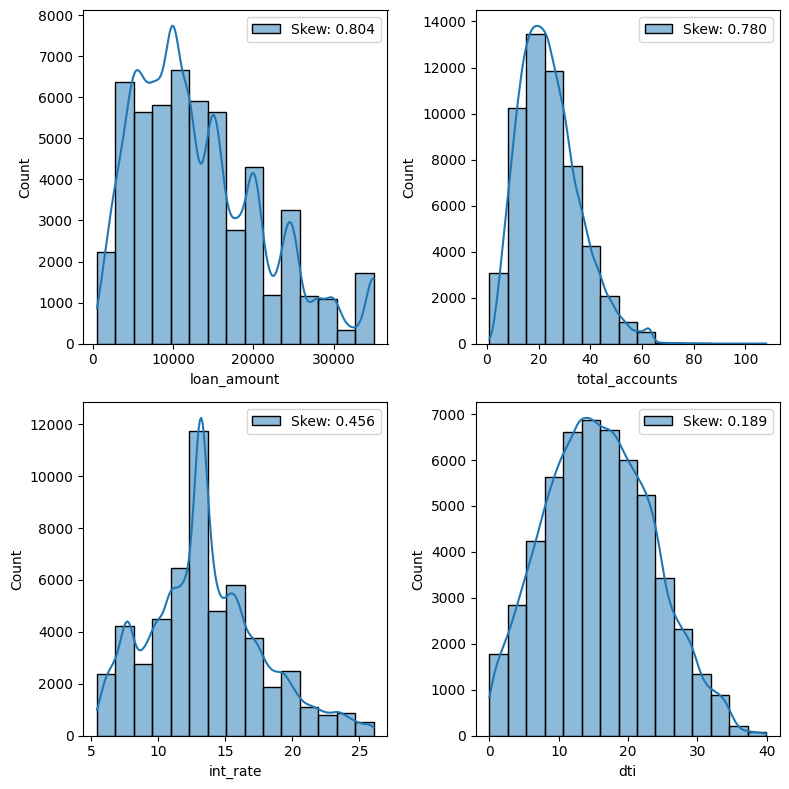

In [120]:
last_four_names = [str(col_name) for col_name in skew_series.tail(4).index]
plotter.plot_histogram_quad(df[last_four_names])

Looking at the plots I notice that the lowest skew values at which skewness becomes apparent is 0.78 for the total_accounts column.

The next lowest is int_rate with a value of 0.456, and that looks normally distributed enough. 

**As a result I am going to set my skew_threshold at 0.5.**

#### Transform skewed columns 

In [121]:
SKEW_THRESHOLD = 0.5

# Extract a series of the columns which are above the threshold.
skewed_columns = skew_series[skew_series > SKEW_THRESHOLD]

# Also store those below the threshold to track progress in reducing skew 
normally_distributed_columns = skew_series[skew_series <= SKEW_THRESHOLD]

Let's see the columns and their skews after applying the skew threshold.

In [122]:
print("Skewed columns:")
print(skewed_columns)
print("")
print("Normally distributed columns:")
print(normally_distributed_columns)

Skewed columns:
annual_inc             8.740078
last_payment_amount    2.495972
out_prncp_inv          2.352797
out_prncp              2.352376
total_rec_int          2.203622
total_payment          1.269351
total_rec_prncp        1.261956
total_payment_inv      1.258693
term                   1.146302
open_accounts          1.059783
instalment             0.996249
funded_amount          0.869145
funded_amount_inv      0.814283
loan_amount            0.804361
total_accounts         0.780251
dtype: float64

Normally distributed columns:
int_rate    0.455883
dti         0.189027
dtype: float64


First I am going to transform the column with the least skew:
`total_accounts` has a skew of `0.779`

In [123]:
column = df["total_accounts"]
msg = plotter.plot_histogram_and_qq(column)
print(msg)

Colum: total_accounts, with skew of 0.78.


In [ ]:
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

Colum: total_accounts, with skew of -0.012.


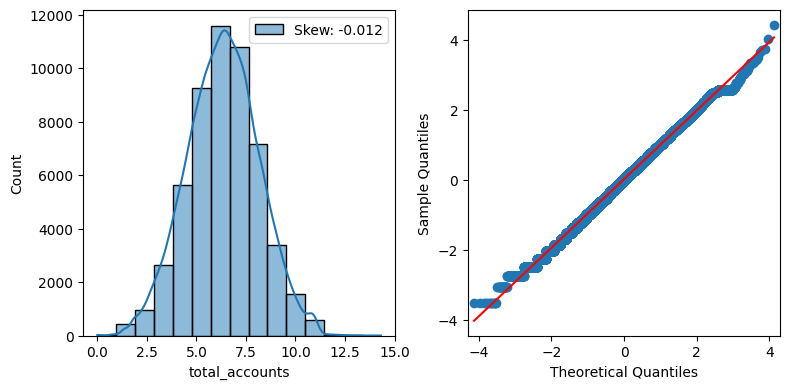

In [ ]:
message = plotter.plot_histogram_and_qq(df["total_accounts"])
print(message)

In [ ]:
# I initially applied a box-cox transform to all of the following columns:
# loan_amount, funded_amount, instalment, total_payment
# I then reversed that decision to retain more of the original data. This improved my ability to gain insights from the data in the coming steps. 

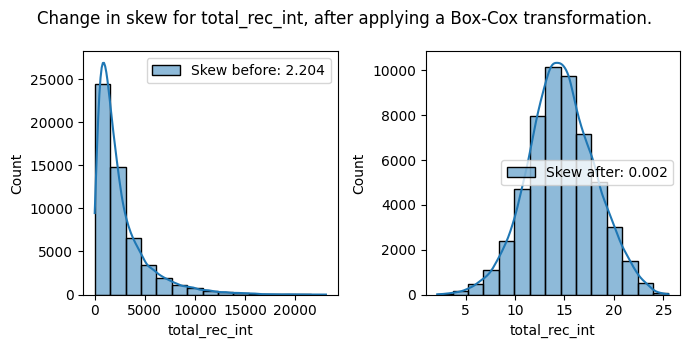

In [ ]:
# Apply box cox transform 
column_before = df['total_rec_int']

transformed_column = df_transformer.box_cox_transform(df["total_rec_int"])
df = df_transformer.replace_column_after_box_cox(df, df["total_rec_int"], transformed_column)

plotter.plot_histogram_before_and_after_transform(column_before, transformed_column, transform_name="Box-Cox")

The columns `total_rec_prncp`, `total_payment_inv` and `funded_amount_inv` contain values equal to 0 and so require a Yeo-Johnson transform instead of a Box-Cox transform. 

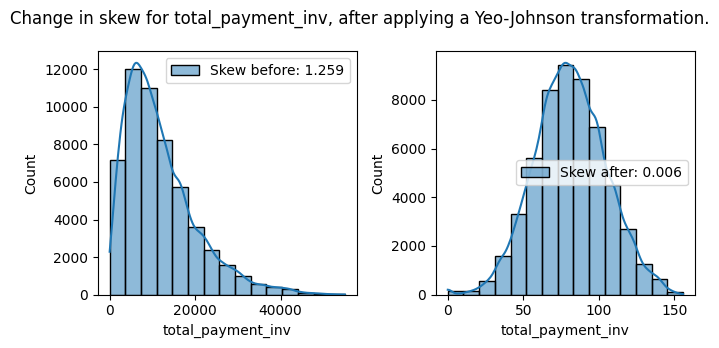

In [ ]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['total_payment_inv']
column_after = df["total_payment_inv"] = df_transformer.yeo_johnson_transform(df['total_payment_inv'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

In [ ]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
# column_before = df['funded_amount_inv']
# column_after = df["funded_amount_inv"] = df_transformer.yeo_johnson_transform(df['funded_amount_inv'])

# plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

In [ ]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
# column_before = df['total_rec_prncp']
# column_after = df["total_rec_prncp"] = df_transformer.yeo_johnson_transform(df['total_rec_prncp'])

# plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

In [ ]:
# get a series showing the skew value for each column
skewed_columns = df_info.get_updated_skew_series(df, to_drop=['id', 'member_id'], threshold=SKEW_THRESHOLD)
normally_distributed_columns = df_info.get_normally_distributed_series(df, to_drop=['id', 'member_id'], threshold=SKEW_THRESHOLD)

print("Skewed columns:")
print(skewed_columns)
print("")
print("Normally distributed columns:")
print(normally_distributed_columns)

Skewed columns:
annual_inc             8.740078
last_payment_amount    2.495972
out_prncp_inv          2.352797
out_prncp              2.352376
total_payment          1.269351
total_rec_prncp        1.261956
term                   1.146302
open_accounts          1.059783
instalment             0.996249
funded_amount          0.869145
funded_amount_inv      0.814283
loan_amount            0.804361
dtype: float64

Normally distributed columns:
int_rate             0.455883
dti                  0.189027
total_payment_inv    0.005941
total_rec_int        0.002199
total_accounts      -0.012415
dtype: float64


### Dropping overly-correlated columns

Print the correlation heatmap for the numeric columns of the data frame 

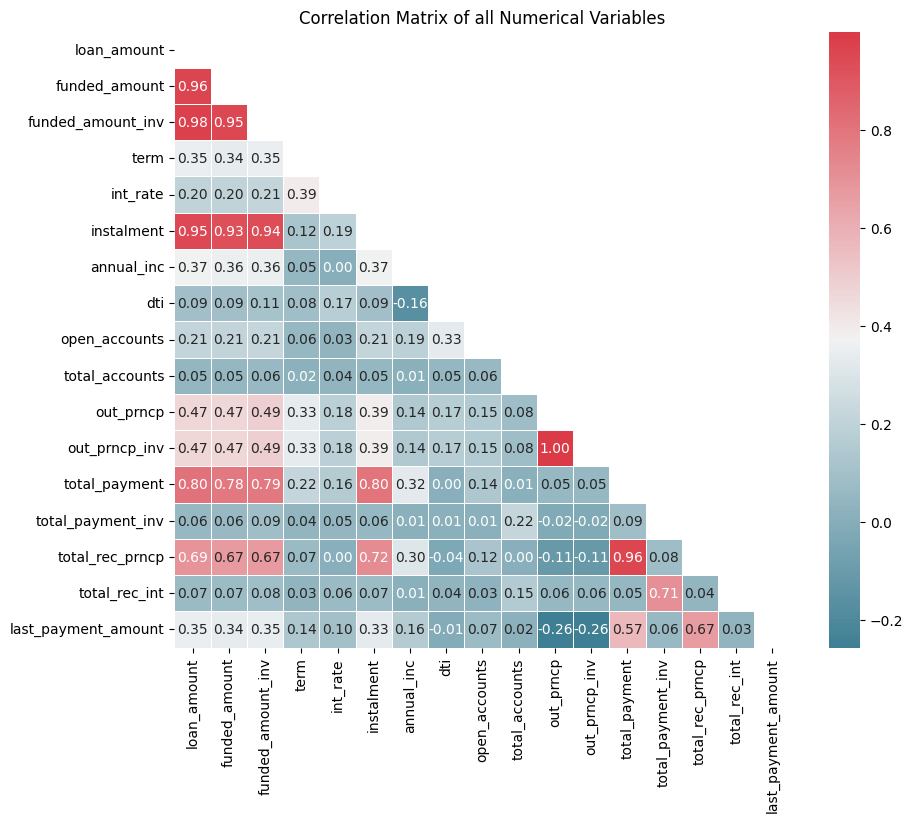

In [ ]:
numeric_df = df_info.get_numeric_columns_from_df(df).drop(['id', 'member_id'], axis=1)
matrix = plotter.correlation_matrix(numeric_df)

I am going to remove all columns with a correlation greater than .90. In each case I will decide which of the two related columns is best to drop.

In [ ]:
# df = df_transformer.drop_column(df, df['instalment'])
df = df_transformer.drop_column(df, df['total_payment_inv'])
df = df_transformer.drop_column(df, df['funded_amount'])
df = df_transformer.drop_column(df, df['total_rec_prncp'])
df = df_transformer.drop_column(df, df['out_prncp_inv'])

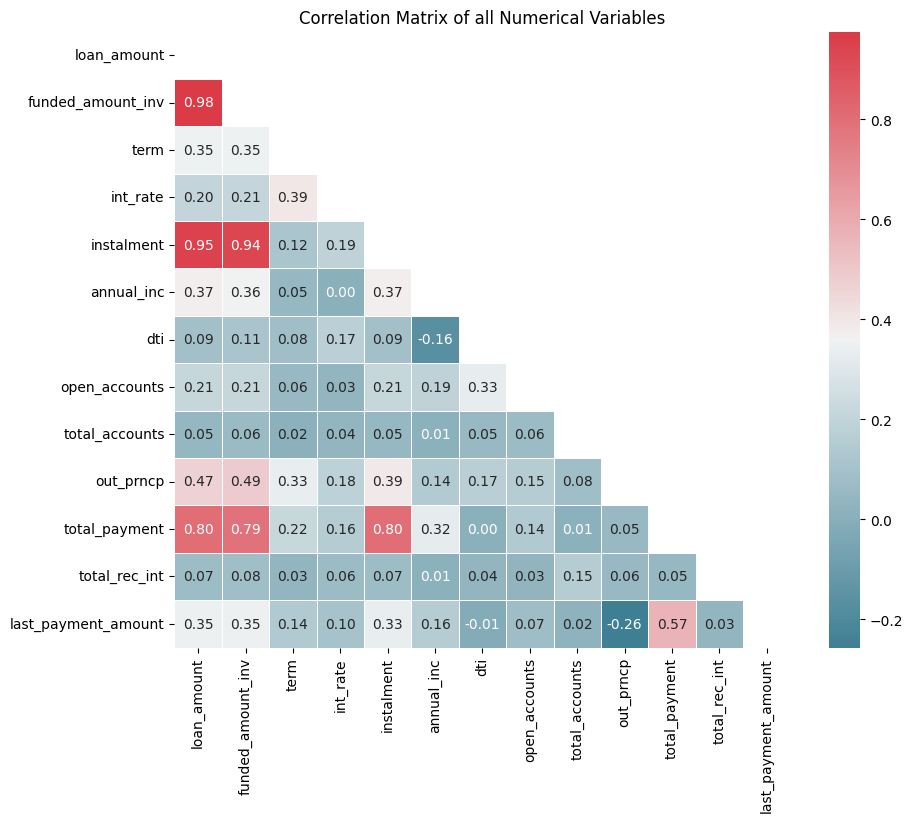

In [ ]:
numeric_df = df_info.get_numeric_columns_from_df(df).drop(['id', 'member_id'], axis=1)
matrix = plotter.correlation_matrix(numeric_df)

In [ ]:
df.head()

,id,member_id,loan_amount,funded_amount_inv,term,int_rate,instalment,sub_grade,employment_length,home_ownership,...,out_prncp,total_payment,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med
0,38676116,41461848,8000,8000.0,36,7.49,248.82,A4,5 years,MORTGAGE,...,5529.70,2982.51,10.850478,0,0,0,2022-01-01,248.82,2022-01-01,0.0
1,38656203,41440010,13200,13200.0,36,6.99,407.52,A3,9 years,RENT,...,9102.83,4885.11,12.088905,0,0,0,2022-01-01,407.52,2022-01-01,0.0
2,38656154,41439961,16000,16000.0,36,7.49,497.63,A4,8 years,MORTGAGE,...,0.00,16824.54,12.224619,0,0,0,2021-10-01,12850.16,2021-10-01,0.0
3,38656128,41439934,15000,15000.0,36,14.31,514.93,C4,1 year,RENT,...,0.00,15947.47,12.646329,0,0,0,2021-06-01,13899.67,2021-06-01,0.0
4,38656121,41439927,15000,15000.0,36,6.03,456.54,A1,10+ years,MORTGAGE,...,10297.47,5473.46,12.024028,0,0,0,2022-01-01,456.54,2022-01-01,0.0


### Data Analysis 

Query the data to check the current state of payments. 

Summarise what percentage of the loans are recovered against the investor funding and the total amount funded.

Extend this query to project what percentage of the total would be recovered up to 6 months' in the future and visualise the data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54095 entries, 0 to 54227
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          54095 non-null  int64         
 1   member_id                   54095 non-null  int64         
 2   loan_amount                 54095 non-null  int64         
 3   funded_amount_inv           54095 non-null  float64       
 4   term                        54095 non-null  int64         
 5   int_rate                    54095 non-null  float64       
 6   instalment                  54095 non-null  float64       
 7   sub_grade                   54095 non-null  category      
 8   employment_length           54095 non-null  category      
 9   home_ownership              54095 non-null  category      
 10  annual_inc                  54095 non-null  float64       
 11  verification_status         54095 non-null  category      


In [ ]:
# Lets have a review of what columns are available to us
df.columns

Index(['id', 'member_id', 'loan_amount', 'funded_amount_inv', 'term',
       'int_rate', 'instalment', 'sub_grade', 'employment_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_date',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line',
       'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp',
       'total_payment', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_payment_date', 'last_payment_amount',
       'last_credit_pull_date', 'collections_12_mths_ex_med'],
      dtype='object')

In [ ]:
# Extract some potentially useful features relating to the state of payments
df.loc[:, ['loan_amount', 'funded_amount_inv', 'total_payment', 'out_prncp', 'loan_status', 'int_rate', 'annual_inc', 'dti']] 
payment_related_columns = df[['loan_amount', 'funded_amount_inv', 'total_payment', 'out_prncp', 'loan_status', 'int_rate', 'annual_inc', 'dti']]
payment_related_columns.head()

,loan_amount,funded_amount_inv,total_payment,out_prncp,loan_status,int_rate,annual_inc,dti
0,8000,8000.0,2982.51,5529.70,Current,7.49,46000.0,19.54
1,13200,13200.0,4885.11,9102.83,Current,6.99,50000.0,24.20
2,16000,16000.0,16824.54,0.00,Fully Paid,7.49,73913.0,16.92
3,15000,15000.0,15947.47,0.00,Fully Paid,14.31,42000.0,35.52
4,15000,15000.0,5473.46,10297.47,Current,6.03,145000.0,3.33


##### Task 1: 


**Summarise what percentage of the loans are recovered against the investor funding and total funding**

According to the correlation heatmap, the amount the investors funded (funded_amount_inv) and the amount funded in total (funded_amount) were 98% correlated, which implies that almost all funding came from investors. 

As a result, the percentage of the loan recovered as a proportion of the total funding and the percentage recovered as a proportion investor funding would be roughly the same.

In [ ]:
# Amount of funding 
funding = df['funded_amount_inv']

# How much of the loan was paid back
amount_recovered = df['total_payment']

# All rows where this value is 'Fully Paid" should have a percentage recovered > 100
loan_status = df["loan_status"]

percentage_recovered_df = pd.DataFrame(data={
    "funding": funding,
    "amount_recovered": amount_recovered,
    "percentage_recovered": round((amount_recovered / funding) * 100, 2),
    "loan_status": loan_status
})

For each loan, show how much of it has been paid back (percentage recovered)

In [ ]:
percentage_recovered_df.head(10)

,funding,amount_recovered,percentage_recovered,loan_status
0,8000.0,2982.51,37.28,Current
1,13200.0,4885.11,37.01,Current
2,16000.0,16824.54,105.15,Fully Paid
3,15000.0,15947.47,106.32,Fully Paid
4,15000.0,5473.46,36.49,Current
5,2525.0,913.60,36.18,Current
6,6675.0,6963.53,104.32,Fully Paid
7,26200.0,4182.27,15.96,Charged Off
8,10000.0,2722.54,27.23,Current
9,10000.0,3766.45,37.66,Current


Another way of summarising this is to see what proportion of all loans have been paid back in full. 

In [ ]:
# A DataFrame containing only loans for which 100% of it has been paid off.  
fully_paid_back_df = percentage_recovered_df[percentage_recovered_df['percentage_recovered'] >= 100.00]

# Use the above DataFrame to work out the percentage of all loans which are fully paid off
total_loan_count = len(percentage_recovered_df)
paid_off_count = len(fully_paid_back_df)
fully_paid_percentage = round((paid_off_count / total_loan_count) * 100, 2)
print(f"Out of {total_loan_count} loans, {paid_off_count} had been fully paid off, which is {fully_paid_percentage}% of them.")

Out of 54095 loans, 30366 had been fully paid off, which is 56.13% of them.


Project what percentage of the total would be recovered up to 6 months' in the future and visualise the data.

In [ ]:
# for each of the loans which are not fully paid off 
# Include the instalment data so we know how much the customer is owes monthly
percentage_recovered_df['monthly_instalment'] = df['instalment']

# Extract all active loans, or those which have not been paid off yet 
loans_not_paid_off = percentage_recovered_df[percentage_recovered_df['percentage_recovered'] < 100.00]

# Add a column showing how much of their loan would be paid off in six months from now - which is the current amount paid off plus 6 months worth of monthly instalments 
loans_not_paid_off.loc[:, 'six_month_projection'] = loans_not_paid_off['amount_recovered'] + (loans_not_paid_off['monthly_instalment'] * 6)

loans_not_paid_off.head()

C:\Users\Student\AppData\Local\Temp\ipykernel_16052\225870947.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_not_paid_off.loc[:, 'six_month_projection'] = loans_not_paid_off['amount_recovered'] + (loans_not_paid_off['monthly_instalment'] * 6)


,funding,amount_recovered,percentage_recovered,loan_status,monthly_instalment,six_month_projection
0,8000.0,2982.51,37.28,Current,248.82,4475.43
1,13200.0,4885.11,37.01,Current,407.52,7330.23
4,15000.0,5473.46,36.49,Current,456.54,8212.70
5,2525.0,913.60,36.18,Current,83.20,1412.80
7,26200.0,4182.27,15.96,Charged Off,701.95,8393.97


In [ ]:
# Use the projected amount paid off in six months to work out what percentage of each loan would be paid back
loans_not_paid_off.loc[:, 'projected_percentage_recovered'] = round((loans_not_paid_off['six_month_projection'] / loans_not_paid_off['funding']) * 100, 2)
loans_not_paid_off.head()

C:\Users\Student\AppData\Local\Temp\ipykernel_16052\152297314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_not_paid_off.loc[:, 'projected_percentage_recovered'] = round((loans_not_paid_off['six_month_projection'] / loans_not_paid_off['funding']) * 100, 2)


,funding,amount_recovered,percentage_recovered,loan_status,monthly_instalment,six_month_projection,projected_percentage_recovered
0,8000.0,2982.51,37.28,Current,248.82,4475.43,55.94
1,13200.0,4885.11,37.01,Current,407.52,7330.23,55.53
4,15000.0,5473.46,36.49,Current,456.54,8212.70,54.75
5,2525.0,913.60,36.18,Current,83.20,1412.80,55.95
7,26200.0,4182.27,15.96,Charged Off,701.95,8393.97,32.04


In [ ]:
# Out of the loans which still are not paid off, use the projected percentage percentgae recovered to work out how many of them would be paid off in 6 months time
total_projected_percentage_paid_off = loans_not_paid_off[loans_not_paid_off['projected_percentage_recovered'] >= 100]

# We know how many loans are currently unpaid, and we know how many are projected to be paid off in six months. Use this to work out the proportion of currently unpaid loans which will be paid off in six months.
num_unpaid_loans = len(loans_not_paid_off)
num_projected_loans_recovered = len(total_projected_percentage_paid_off)

projected_num_loans_recovered = round((num_projected_loans_recovered / num_unpaid_loans) * 100, 2)
print(f"Out of the {num_unpaid_loans} currently unpaid loans, {num_projected_loans_recovered} are projected to be fully paid off in 6 months, which is {projected_num_loans_recovered}% of them.")

Out of the 23729 currently unpaid loans, 9020 are projected to be fully paid off in 6 months, which is 38.01% of them.


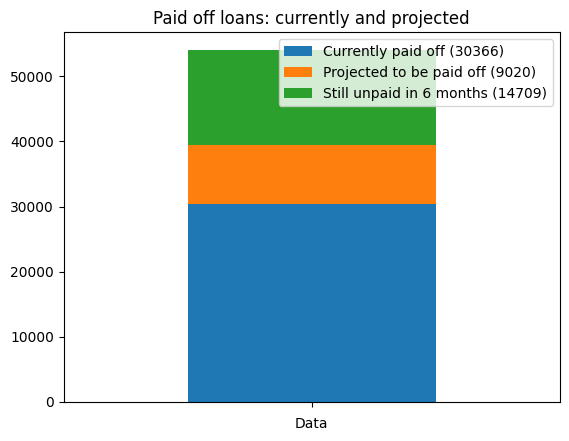

In [ ]:
rest_of_loans = total_loan_count - (paid_off_count + num_projected_loans_recovered)

# Calculate percentages 

# create data
data_to_plot = pd.DataFrame([['', paid_off_count, num_projected_loans_recovered, rest_of_loans]],
                  columns=['Data', f'Currently paid off ({paid_off_count})', f'Projected to be paid off ({num_projected_loans_recovered})', f'Still unpaid in 6 months ({rest_of_loans})'])

plotter.stacked_bar_plot(data_to_plot, 'Paid off loans: currently and projected')

##### Task 2: 


**Calculate the percentage of charged off loans historically and amount that was paid towards these loans before being charged off.**

Loans marked as Charged Off in the loan_status column represent a loss to the company.

In [ ]:
# Extract relavent features
data = df[['loan_status', 'total_payment', 'loan_amount']]

What percentage of loans were charged off?

In [ ]:
# Extract charged off rows
charged_off = data[data['loan_status'] == 'Charged Off']

# Calculate the total number of loans and how many were charged off
total_count = len(data['loan_status'].index)
charged_off_count = len(charged_off.index)

charged_off_proportion = round((charged_off_count / total_count) * 100, 2)
print(f'Of the {total_count} loans, {charged_off_count} were charged off, which is {charged_off_proportion}%')

Of the 54095 loans, 5498 were charged off, which is 10.16%


How much was paid towards these loans before they were charged off?

In [ ]:
average_charged_off = round(charged_off['total_payment'].mean(), 2)
total_charged_off = round(charged_off['total_payment'].sum(), 2)
print(f'In total, £{total_charged_off} was paid towards the loans which were charged off.')
print(f'On average, £{total_charged_off} was paid towards the loans which were charged off.')

In total, £37234198.82 was paid towards the loans which were charged off.
On average, £37234198.82 was paid towards the loans which were charged off.


##### Task 3


**Calculate the projected loss of the loans marked as Charged Off.**

Based on the interest rate of the loan and the loans term, you can calculate how much revenue the loan would have generated for the company. 

Perform this calculation to check the total percentage of expected revenue that was lost and the increase in revenue this would have been for the company.

In [ ]:
# Extract relavent features
data = df[['loan_status', 'int_rate', 'term','total_payment', 'loan_amount']]

# Filter to only include charged off loans 
data = data[data['loan_status'] == 'Charged Off']

Calculate the total interest that could have been generated from each charged off loan using the following formula:

`expected_revenue = original_loan_amount x (int_rate / 12) x term (in months)`

In [ ]:
data['expected_revenue (£)'] = data['loan_amount'] * (data['int_rate'] / 12) * data['term']

In [ ]:
data.head()

,loan_status,int_rate,term,total_payment,loan_amount,expected_revenue (£)
7,Charged Off,19.99,36,4182.27,26500,1589205.0
56,Charged Off,16.49,60,1906.51,11200,923440.0
83,Charged Off,17.14,36,282.78,1325,68131.5
90,Charged Off,19.99,36,1808.05,8150,488755.5
117,Charged Off,12.99,36,1654.14,7000,272790.0


##### Task 4

**There are customers who are currently behind with their loan payments; this subset of customers represent a risk to company revenue.**

- What percentage do users' in this bracket currently represent as a percentage of all loans? 

- Calculate the total amount of customers in this bracket and how much loss the company would incur if these users status changed to Charged Off. What is the projected loss of these loans if the customer were to finish the loans term?

- If these customers were converted to Charged Off, what percentage of total revenue do these customers and the customers who have already defaulted on their loan represent?

In [ ]:
# Those who are behind on their loan have a loan_status of 'Late (16-30 days)' or 'Late (31-120 days)'
# Extract relavent features
data = df[['loan_status', 'int_rate', 'term','total_payment', 'loan_amount', 'instalment']]

# Filter to only include charged off loans 
data = data[(data['loan_status'] == 'Late (16-30 days)') | (data['loan_status'] == 'Late (31-120 days)')]

In [ ]:
# What percentage do users' in this bracket currently represent as a percentage of all loans? 
total_loans = len(df.index)
behind_loans = len(data.index)

behind_loans_proportion = round((behind_loans / total_loans) * 100, 2)
print(f'Of the {total_loans} loans, {behind_loans} are behind on their payments, which is {behind_loans_proportion}% of all loans.')

Of the 54095 loans, 686 are behind on their payments, which is 1.27% of all loans.


In [ ]:
# Calculate the total amount of customers in this bracket  
print(f'There are {behind_loans} customers in this bracket.')

# How many months have they paid already - i.e. how many months are left in their term?
months_left = pd.Series(data['term'] - round(data['total_payment'] / data['instalment']))

monthly_interest = data['int_rate'] / 12

# Calculate how much loss the company would incur if these users status changed to Charged Off
data['potenial_loss_incurred (£)'] = pd.Series(data['loan_amount'] * monthly_interest * months_left).round(2)

There are 686 customers in this bracket.


In [ ]:
data.head()

,loan_status,int_rate,term,total_payment,loan_amount,instalment,potenial_loss_incurred (£)
17,Late (31-120 days),13.66,60,3883.91,18825,434.72,1092885.38
140,Late (31-120 days),14.99,36,5394.11,15600,540.71,506662.00
168,Late (31-120 days),8.67,36,1908.02,6000,189.88,112710.00
171,Late (31-120 days),13.16,36,3764.14,15000,471.37,460600.00
243,Late (16-30 days),11.44,36,1808.96,5000,164.74,119166.67


If these customers were converted to Charged Off, what percentage of total revenue do these customers and the customers who have already defaulted on their loan represent?

In [ ]:
# Loans which are up to date include those fully paid, and those on track (current)
up_to_date_loans = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Current')]

# The following are the 'rest' of the loans
defaulted_loans = df[df['loan_status'] == 'Default']
charged_off_loans = df[(df['loan_status'] == 'Charged Off')]
late_loans = df[(df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Late (16-30 days)')]

In [ ]:
# Calculate each of their revenue's using the formula revenue = loan_amount x (int_rate / 12) x term`
up_to_date_revenue = df_transformer.calculate_revenue(up_to_date_loans)

defaulted_revenue = df_transformer.calculate_revenue(defaulted_loans)

charged_off_revenue = df_transformer.calculate_revenue(charged_off_loans)

late_revenue = df_transformer.calculate_revenue(late_loans)

In [ ]:
unpaid_loans_revenue = defaulted_revenue + late_revenue + charged_off_revenue

total_revenue = up_to_date_revenue + unpaid_loans_revenue

unpaid_proportion_of_total_revenue = round((unpaid_loans_revenue / total_revenue) * 100, 2)

print(f'Potential revenue from unpaid loans (defaulted, charged off, and late) is {data_formatter.float_to_money_format(unpaid_loans_revenue)}.')
print(f'Revenue made from paid off loans, and those currently on target is {data_formatter.float_to_money_format(up_to_date_revenue)}.')
print(f'Total potential revenue is a combination of the above two numbers, which is {data_formatter.float_to_money_format(unpaid_loans_revenue + up_to_date_revenue)}')
print(f'Proportion of revenue made from the unpaid loans, as a proportion of the total revenue is {unpaid_proportion_of_total_revenue}%.')


Potential revenue from unpaid loans (defaulted, charged off, and late) is £5,565,736,402.00.
Revenue made from paid off loans, and those currently on target is £32,147,991,742.00.
Total potential revenue is a combination of the above two numbers, which is £37,713,728,144.00
Proportion of revenue made from the unpaid loans, as a proportion of the total revenue is 14.76%.


##### Task 5

**Visualise the possible indicators that a customer will not be able to pay the loan.**

Compare columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.

Here are some example columns that might indicate that a user might not pay the loan:

- Does the `grade` of the loan have effect on customers not paying?
- Is the reason (`purpose`) for the loan likely to have an effect?
- Does the `dti` value contribute to the likelihood a customer won't pay?

To help identify which columns will be of interest, create a subset of these users and plot another correlation matrix to work out which columns are of interest.

Execute the analysis and determine the columns contributing to loans not being paid off. Visualise any interesting indicators.

Compare the indicators between loans already charged off and loans which could change to charged off to check whether you can determine some risk factors for currently behind loans.

In [ ]:
df.head()

,id,member_id,loan_amount,funded_amount_inv,term,int_rate,instalment,sub_grade,employment_length,home_ownership,...,out_prncp,total_payment,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med
0,38676116,41461848,8000,8000.0,36,7.49,248.82,A4,5 years,MORTGAGE,...,5529.70,2982.51,10.850478,0,0,0,2022-01-01,248.82,2022-01-01,0.0
1,38656203,41440010,13200,13200.0,36,6.99,407.52,A3,9 years,RENT,...,9102.83,4885.11,12.088905,0,0,0,2022-01-01,407.52,2022-01-01,0.0
2,38656154,41439961,16000,16000.0,36,7.49,497.63,A4,8 years,MORTGAGE,...,0.00,16824.54,12.224619,0,0,0,2021-10-01,12850.16,2021-10-01,0.0
3,38656128,41439934,15000,15000.0,36,14.31,514.93,C4,1 year,RENT,...,0.00,15947.47,12.646329,0,0,0,2021-06-01,13899.67,2021-06-01,0.0
4,38656121,41439927,15000,15000.0,36,6.03,456.54,A1,10+ years,MORTGAGE,...,10297.47,5473.46,12.024028,0,0,0,2022-01-01,456.54,2022-01-01,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54095 entries, 0 to 54227
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          54095 non-null  int64         
 1   member_id                   54095 non-null  int64         
 2   loan_amount                 54095 non-null  int64         
 3   funded_amount_inv           54095 non-null  float64       
 4   term                        54095 non-null  int64         
 5   int_rate                    54095 non-null  float64       
 6   instalment                  54095 non-null  float64       
 7   sub_grade                   54095 non-null  category      
 8   employment_length           54095 non-null  category      
 9   home_ownership              54095 non-null  category      
 10  annual_inc                  54095 non-null  float64       
 11  verification_status         54095 non-null  category      
